#  Distributed Data Parallel (DDP) trainig on AMD GPU with ROCm

As machine learning models increase in complexity and size, the demand for computational resources grows. Single-GPU training can become a bottleneck, especially with large datasets and models that are slow to train on a single GPU. Parallelized training addresses this challenge. There are various forms of parallelized training, and this blog will focus on Distributed Data Parallel (DDP), a key feature in PyTorch that accelerates training across multiple GPUs and nodes.

This blog will demonstrate how to speed up the training of a ResNet model on the CIFAR-100 classification task using PyTorch DDP on AMD GPUs with ROCm.

## Distributed Data Parallel (DDP)
[DistributedDataParallel](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) (DDP) enables model training across multiple GPUs or nodes by implementing data parallelism at the module level. In DDP training, multiple processes are spawned, each hosting a single DDP instance, with every process owning a replica of the model. During the forward pass, each process handles a distinct batch of data in parallel by passing inputs to its local model.

In the backward pass, the `backward()` function is called on the loss tensor within each process, which computes gradients for the model parameters. Once all processes have computed their gradients, DDP asynchronously triggers an `allreduce` operation to average the gradients across all processes. These averaged gradients are then written to the `param.grad` field of the model's parameters in every process.

Each process maintains its optimizer, performing a full optimization step during each iteration. The optimizer updates the local model using these gradients, ensuring model replicas remain synchronized across processes, as they start with the same state and share the averaged gradients after each iteration. For more details, refer to the [Pytorch Distributed Data Parallel Overview](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) and [Pytorch Distributed Data Parallel Design](https://pytorch.org/docs/main/notes/ddp.html)

## Setup

This blog was created using the following setup. For comprehensive support details about the setup, please refer to the [ROCm documentation](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/).

* Hardware & OS:
  * [AMD Instinct GPU](https://www.amd.com/en/products/accelerators/instinct.html)
  * Ubuntu 22.04.3 LTS
* Software:
  * [ROCm 6.1+](https://rocm.docs.amd.com/projects/install-on-linux/en/develop/how-to/amdgpu-install.html)
  * [PyTorch 2.1+ for ROCm](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/how-to/3rd-party/pytorch-install.html)
  
In this blog, we utilize the [`rocm/pytorch:rocm6.2_ubuntu20.04_py3.9_pytorch_release_2.1.2`](https://hub.docker.com/layers/rocm/pytorch/rocm6.2_ubuntu20.04_py3.9_pytorch_release_2.1.2/images/sha256-58186da550e3d83c5b598ce0c1f581206eabd82c85bd77d22b34f5695d749762?context=explore) docker image on two nodes each equipped with 8 MI300x GPUs.

## Getting Started

We use the [`rocm/pytorch:rocm6.2_ubuntu20.04_py3.9_pytorch_release_2.1.2`](https://hub.docker.com/layers/rocm/pytorch/rocm6.2_ubuntu20.04_py3.9_pytorch_release_2.1.2/images/sha256-58186da550e3d83c5b598ce0c1f581206eabd82c85bd77d22b34f5695d749762?context=explore) Docker image for this blog.

You can find the complete source code used by this blog in this [rocm-blogs Github repo](https://github.com/ROCm/rocm-blogs/tree/release/blogs/artificial-intelligence/ddp-training).  In the following sections, the code related to applying DDP will be highlighted.

> Note
    If the focus is solely on running the training and checking the results, please refer to the Multi-GPU and Multi-Node Training section.

Import the necessary packages.

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import torch.distributed as dist

import time
import os

The `torch.distributed` package offers support and communication primitives for multiprocess parallelism across multiple computation nodes, either on a single machine or across several machines. The `torch.nn.parallel.DistributedDataParallel()` class builds on this functionality, providing synchronous distributed training by wrapping any PyTorch model. To use `DDP` with a PyTorch model, the first step is to initialize both the default distributed process group and the distributed package.

In [ ]:
# nccl is recommaed by pytorch for distributed GPU training
dist.init_process_group(backend="nccl") 

The following command can be used to check the process id, along with the local and global ranks. Generally, each process is assigned to a specific GPU.

In [ ]:
global_rank = int(os.environ["RANK"])
local_rank = int(os.environ["LOCAL_RANK"])
print(f"Hello from local_rank {local_rank}, global_rank {global_rank}")

To use `DDP` on a host with N GPUs, N processes should be spawned, with each process assigned to a specific GPU, ranging from 0 to N-1. This can be achieved by calling:

In [ ]:
torch.cuda.set_device(local_rank)

Create the Resnet101 model and warp it with `torch.nn.parallel.DistributedDataParallel()` for DDP training.

In [ ]:
model = torchvision.models.resnet101(weights='IMAGENET1K_V1')
#change the output since we are using CIFAR100
model.fc = torch.nn.Linear(model.fc.in_features, 100)

device = torch.device("cuda:{}".format(local_rank))
model = model.to(device)
ddp_model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)

# Prepare dataset and dataloader
In DDP, each process can pass a `DistributedSampler` instance as a DataLoader sampler. the DistributedSampler ensures each device gets a non-overlapping input batch for training.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR100(root="./data", train=True, download=False, transform=transform) 
test_dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False, transform=transform)

# Restricts data loading to a subset of the dataset exclusive to the current process
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=DistributedSampler(dataset=train_dataset), shuffle=False, num_workers=16)

# We will only test on rank 0
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

Prepare loss function and optimzer.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(ddp_model.parameters(), lr=learning_rate, momentum=0.9)

Helper functions to evaluate the model on test dataset during training.

In [ ]:
def evaluate_on_test_data(model, device, test_loader):
    model.eval()
    correct_num = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            total += len(labels)
            correct_num += (predicted == labels).sum().item()

    return correct_num / total

Helper functions to train on epoch.

In [ ]:
# function used to train one epoch
def train_epoch(model, dataloader, criterion, optimizer, device, bs):  # bs: bach size
    model.train()  
    total_loss = 0  
    total_correct = 0  

    for batch in dataloader:
        images, labels = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad() # reset gradients 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = outputs.argmax(dim=1)

        correct_num = (predictions == labels).sum().item()
        total_correct += correct_num

    return total_loss / len(dataloader), total_correct / (len(dataloader)*bs)


After wrapping the original model with `torch.nn.parallel.DistributedDataParallel()`, the `ddp_model` can be used like any other model in the training loop, without requiring any changes. The key point to remember is that each process/GPU will run the training loop in parallel, with its own replica of the model and optimizer.

In [ ]:
log_epoch = 0
# Training Loop
training_start = time.perf_counter()
for epoch in range(num_epochs):
    log_epoch += 1
    epoch_start_time = time.perf_counter()

    ddp_model.train()
    # In distributed mode, calling the set_epoch() method at the beginning of each epoch 
    # is necessary to make shuffling work properly across multiple epochs. 
    # Otherwise, the same ordering will be always used.
    train_loader.sampler.set_epoch(epoch)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, batch_size)

    torch.cuda.synchronize()
    epoch_end_time = time.perf_counter()

    if  global_rank  == 0:
        print(f"Epoch - {epoch}/{num_epochs}: time - {(epoch_end_time - epoch_start_time):.4f}s || loss_train - {train_loss:.4f} || accuracy_train - {train_acc:.4f}")
        if epoch % log_every == 0:
            test_accuracy = evaluate_on_test_data(model=ddp_model, device=device, test_loader=test_loader)
            print(f"Accuracy on test dataset - {test_accuracy:.4f}")


torch.cuda.synchronize()
training_end = time.perf_counter()
if global_rank == 0:
    print(f"Training took {(training_end - training_start):.4f}s")
    torch.save(ddp_model.state_dict(), model_filepath)

After the training is completed, it's recommanded to destroy the process group, and deinitialize the distributed package

In [ ]:
dist.barrier()
dist.destroy_process_group()

The following are the configurations used by the training.

In [ ]:
# training configuration 
num_epochs = 100
batch_size = 1024
learning_rate = 0.002
model_dir = "saved_ddp_models"
model_filename = "resnet_ddp.pth"
log_every = 5

model_filepath = os.path.join(model_dir, model_filename)

# we need GPUs
assert torch.cuda.is_available(), "DDP requires at least one GPU."

## Multi-GPU and Multi-Node Training

Donwload the dataset.

In [ ]:
%%bash 
mkdir data && wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz -P ./data
cd ./data
tar -xvzf cifar-10-python.tar.gz

After downloading the script, DDP training of a ResNet model on the CIFAR-100 dataset can be run using varying numbers of GPUs and nodes. It is recommended to use `torchrun` for launching distributed training, as it automatically sets environment variables such as `WORLD_SIZE`, `WORLD_RANK`, and `LOCAL_RANK` for each process, based on parameters like `nproc_per_node` and `nnodes`. Learn more about it [here](https://pytorch.org/docs/stable/elastic/run.html).

### Single node and single GPU

In [ ]:
%%bash 
torchrun --nnodes 1 --nproc_per_node 1 ./resnet_ddp.py

Output:
```text
Hello from local_rank 0, global_rank 0
Epoch - 0/100: time - 72.5210s || loss_train - 4.3878 || accuracy_train - 0.1079
Accuracy on test dataset - 0.2954
Epoch - 1/100: time - 62.7779s || loss_train - 3.3265 || accuracy_train - 0.4390
...
Epoch - 95/100: time - 64.4887s || loss_train - 0.0040 || accuracy_train - 0.9963
Accuracy on test dataset - 0.8252
Epoch - 96/100: time - 64.5610s || loss_train - 0.0039 || accuracy_train - 0.9962
Epoch - 97/100: time - 65.1033s || loss_train - 0.0039 || accuracy_train - 0.9962
Epoch - 98/100: time - 63.7450s || loss_train - 0.0038 || accuracy_train - 0.9962
Epoch - 99/100: time - 65.1572s || loss_train - 0.0037 || accuracy_train - 0.9963
Training took 6562.1979s
```

The training and test accuracy reached `82.52%` and `99.63%`, respectively, while the training loss decreased from `4.39` to `0.0037`. Each epoch took approximately `65 seconds`. These single-GPU training results will serve as a baseline for evaluating multi-GPU and multi-node training with DDP.

### Single node and mutilpe GPUs training 

`nnodes` and `nproc_per_node` specify the number of nodes and the number of processes per node allocated for training, respectively. For single-node training, configurations with 1, 2, 4, and 8 processes are tested.

In [ ]:
%%bash 
torchrun --nnodes 1 --nproc_per_node 2 ./resnet_ddp.py

Output:
```text
    Hello from local_rank 0, global_rank 0
    Hello from local_rank 1, global_rank 1
    ...
    Epoch - 95/100: time - 32.7166s || loss_train - 0.0154 || accuracy_train - 0.9759
    Accuracy on test dataset - 0.8305
    Epoch - 96/100: time - 32.5770s || loss_train - 0.0148 || accuracy_train - 0.9760
    Epoch - 97/100: time - 32.6447s || loss_train - 0.0141 || accuracy_train - 0.9761
    Epoch - 98/100: time - 32.4623s || loss_train - 0.0132 || accuracy_train - 0.9762
    Epoch - 99/100: time - 33.2162s || loss_train - 0.0133 || accuracy_train - 0.9762
    Training took 3389.0880s
```

In [ ]:
%%bash 
torchrun --nnodes 1 --nproc_per_node 4 ./resnet_ddp.py

Output:
```text
Hello from local_rank 3, global_rank 3
Hello from local_rank 1, global_rank 1
Hello from local_rank 2, global_rank 2
Hello from local_rank 0, global_rank 0
...
Epoch - 95/100: time - 17.1800s || loss_train - 0.1151 || accuracy_train - 0.9197
Accuracy on test dataset - 0.8333
Epoch - 96/100: time - 17.1674s || loss_train - 0.1113 || accuracy_train - 0.9211
Epoch - 97/100: time - 17.5608s || loss_train - 0.1050 || accuracy_train - 0.9220
Epoch - 98/100: time - 16.9875s || loss_train - 0.0994 || accuracy_train - 0.9247
Epoch - 99/100: time - 16.9966s || loss_train - 0.1034 || accuracy_train - 0.9228
Training took 1868.7733s
```

In [ ]:
%%bash 
torchrun --nnodes 1 --nproc_per_node 8 ./resnet_ddp.py

Output:
```text
Hello from local_rank 0, global_rank 0
Hello from local_rank 5, global_rank 5
Hello from local_rank 7, global_rank 7
Hello from local_rank 4, global_rank 4
Hello from local_rank 1, global_rank 1
Hello from local_rank 3, global_rank 3
Hello from local_rank 6, global_rank 6
Hello from local_rank 2, global_rank 2
...
Epoch - 95/100: time - 9.4085s || loss_train - 0.3887 || accuracy_train - 0.7819
Accuracy on test dataset - 0.8257
Epoch - 96/100: time - 9.5595s || loss_train - 0.3690 || accuracy_train - 0.7867
Epoch - 97/100: time - 9.5188s || loss_train - 0.3789 || accuracy_train - 0.7847
Epoch - 98/100: time - 9.5819s || loss_train - 0.3561 || accuracy_train - 0.7879
Epoch - 99/100: time - 9.5800s || loss_train - 0.3567 || accuracy_train - 0.7871
Training took 1142.1704
```

### Mutiple nodes training

Slurm or manual methods can be used to launch training across multiple nodes. In this blog, DDP training will be manually launched on two nodes, each with eight GPUs, to focus on the training process.

For the two-node setup, Docker containers need to be launched separately on each node. The IP address of one node (e.g., 10.168.265.147) should be retrieved and used in the next steps. The command provided must be run on both nodes, specifying the number of nodes, the number of processes per node, and the backend for the rendezvous (c10d).

The Collective Communication (c10d) library enables tensor transmission across processes within a group, offering both collective communication APIs (e.g., all_reduce, all_gather) and peer-to-peer communication APIs. Further details can be found[here](https://tutorials.pytorch.kr/beginner/dist_overview.html).

In [ ]:
%%bash 
docker pull rocm/pytorch:rocm6.2_ubuntu20.04_py3.9_pytorch_release_2.1.2
docker run -it --name vision_mamba --rm --ipc=host \
            --device=/dev/kfd --device=/dev/dri/ \
             --network=host --group-add=video --shm-size 8G \
            rocm/pytorch:rocm6.2_ubuntu20.04_py3.9_pytorch_release_2.1.2

In [ ]:
%%bash
torchrun --nnodes 2 --nproc_per_node 8 --rdzv_id 2024 --rdzv_backend c10d --rdzv_endpoint 10.168.265.147 ./resnet_ddp.py

Output from the first node:
```text
Hello from local_rank 1, global_rank 1
Hello from local_rank 3, global_rank 3
Hello from local_rank 6, global_rank 6
Hello from local_rank 4, global_rank 4
Hello from local_rank 2, global_rank 2
Hello from local_rank 7, global_rank 7
Hello from local_rank 5, global_rank 5
Hello from local_rank 0, global_rank 0
...
Epoch - 95/100: time - 5.8633s || loss_train - 0.6961 || accuracy_train - 0.6140
Accuracy on test dataset - 0.7752
Epoch - 96/100: time - 5.9370s || loss_train - 0.6777 || accuracy_train - 0.6292
Epoch - 97/100: time - 5.8459s || loss_train - 0.6944 || accuracy_train - 0.6182
Epoch - 98/100: time - 5.8597s || loss_train - 0.6694 || accuracy_train - 0.6299
Epoch - 99/100: time - 5.9061s || loss_train - 0.6687 || accuracy_train - 0.6270
Training took 725.0729
```
Output from the second node:
```text
Hello from local_rank 2, global_rank 10
Hello from local_rank 0, global_rank 8
Hello from local_rank 5, global_rank 13
Hello from local_rank 6, global_rank 14
Hello from local_rank 1, global_rank 9
Hello from local_rank 7, global_rank 15
Hello from local_rank 4, global_rank 12
Hello from local_rank 3, global_rank 11
```

In the training script only rank #0 process prints the the metrics, which eaplains why there is no metrics output from the second node.

### Results analysis

#### Loss and accuracy

To intuitively analyze the DDP training, the `training loss`, `train accuracy`, and `test accuracy` results from the previous tests are visualized in the following plot. `1_1` indicates that one node with one GPU was used for training, while `1_2` means one node with two GPUs was used, and so on.


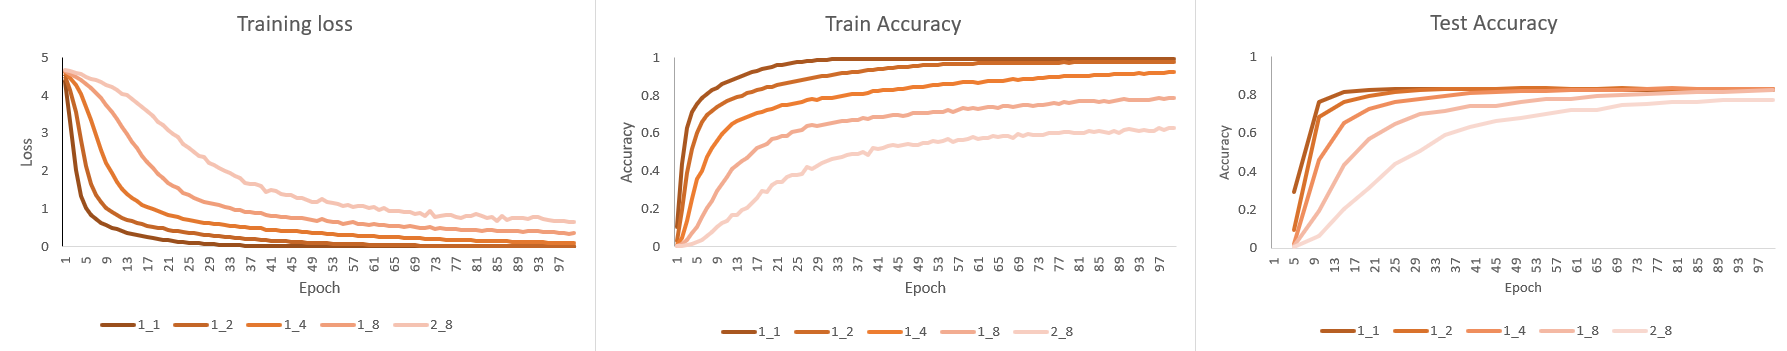

From the plot, it is observed that the `1_1` configuration (one node, one GPU) converges in the fewest epochs compared to other setups. As more GPUs are used with DDP, the number of epochs required to converge increases. Additionally, training with a single GPU achieves the highest accuracy, while the `2_8` configuration (two nodes, eight GPUs) yields the lowest accuracy.

**Why DDP doesn't work well with more GPUs?**

During training, each process (or GPU) has its own model replica, and in each iteration, all processes perform a forward pass on a batch of data exclusive to them. For example, training on a single GPU with a `batch_size = bs`, and using DDP with `N` GPUs while keeping the `batch_size = bs` results in `N * bs` data being processed in parallel per iteration. This is equivalent to training on a single GPU with a batch size of `N * bs`. While larger batch sizes lead to faster training, as they allow the entire dataset to be processed in fewer steps, empirical evidence suggests that large batch sizes often converge to sharp minima, which can result in poorer generalization. On the other hand, smaller batch sizes tend to converge to flatter minima, leading to better generalization.

**How can the same training accuracy achieved on a single GPU be reproduced when using DDP on multiple GPUs?**

To improve convergence speed and accuracy in DDP training with multiple GPUs/nodes, one approach is to scale the learning rate as the global batch size increases. Alternatively, the global batch size can remain unscaled when increasing the number of GPUs/nodes. This can be achieved by adjusting the `bathch_size` to `batch_size //= dist.get_world_size()`, where the 'dist.get_world_size()' gives the total number of processes used by DDP. 

After making this adjustment and rerunning the previous five DDP training tests with `--batch_size_scaled`, the training loss and accuracy consistently change, aligning better with the results from single-GPU training. Here is an example to run the DDP training with 1 node 8 GPUs.

In [ ]:
%%bash 
torchrun --nnodes 1 --nproc_per_node 8 ./resnet_ddp.py --batch_size_scaled

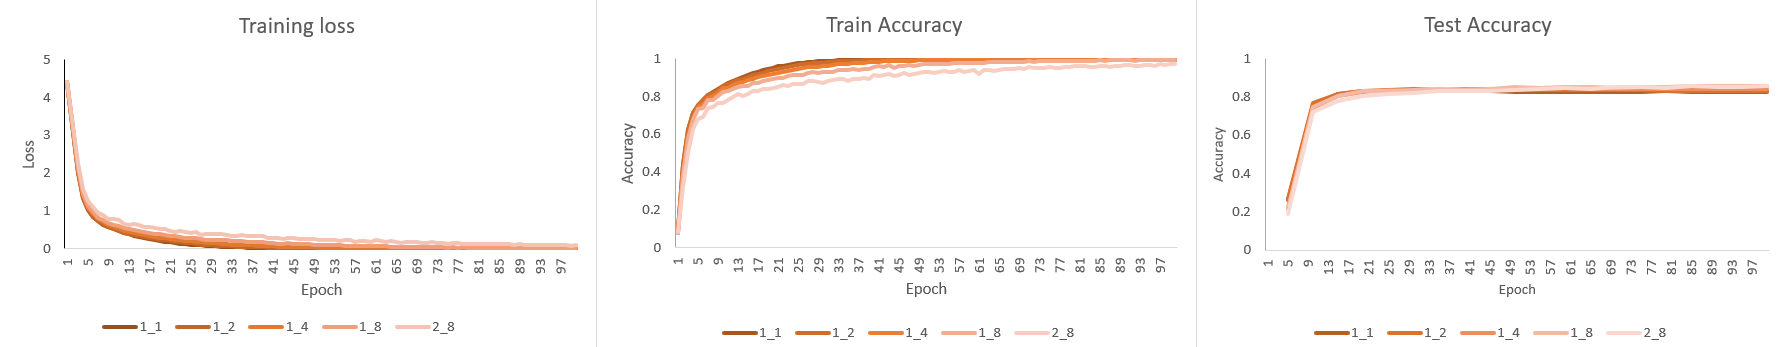

#### Training Speed

The following plot illustrates the time spent per epoch during training with varying numbers of GPUs and nodes. As the number of GPUs used for DDP increases, the training time decreases significantly. With the batch size unscaled, DDP training on two nodes and eight GPUs achieves the same accuracy with approximately `13x` speedup.

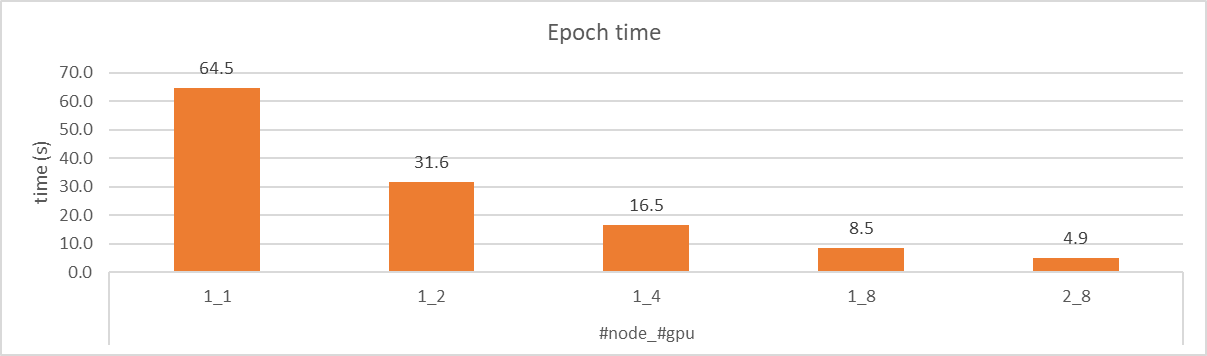

## Conclusion
Pytorch Distributed Data Parallel (DDP) training, seamlessly working with AMD GPUs using ROCm, offers a scalable and efficient solution for training deep learning models across multiple GPUs and nodes. As demonstrated in this blog, DDP can significantly reduce training time while maintaining accuracy, especially when leveraging multiple GPUs or nodes.

In upcoming blogs, we will explore additional parallel training methods, including Fully Sharded Data Parallel (FSDP), tensor parallelism, and pipeline parallelism.

Reference:
1. [On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima
](https://arxiv.org/abs/1609.04836)